<a href="https://colab.research.google.com/github/cagdastopcu/omission-of-visual-stimuli/blob/main/wilson_cowan_2population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wilson-Cowan model for PYR, SST, and VIP neuronal populations

In [87]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
def runge_kutta4(func, r, t, h,I_ext_E):
    """ 
    Runge-Kutta 4 method for solving 1st order differential equations
    
    Usage: r_updated (+)= rk4(func, r, t, h) 
    
    Given a function  f(x, t, h) = dx/dt and initial starting 
    conditions for x, rk4() returns the next/updated values of x. 
    func:  user defined function for the 1st order differential equations
    r: dependent variable(s)
    t: independent variable(s)
    h: independent variable step value
    I_ext_E: external input value
    """
    k1 = h*func(r, t,I_ext_E)
    k2 = h*func(r+0.5*k1, t+0.5*h,I_ext_E)
    k3 = h*func(r+0.5*k2, t+0.5*h,I_ext_E)
    k4 = h*func(r+k3, t+h,I_ext_E)
    return (k1 + 2*k2 + 2*k3 + k4)/6
    #return k1

def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = np.maximum((1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1,0.)
  #f =  1 / (1 + np.exp(-x))

  return f

def wilson_cowan(r, t,I_ext_E):
    """ Vectorized function for the Wilson-Cowan model """
    
    x1 = r[0] #firing rate of PYR
    v1 = r[1] 
    x2 = r[2] #firing rate of SST
    v2 = r[3]
    x3 = r[4] #firing rate of VIP
    v3 = r[5]


    # Excitatory parameters
    tau_E = 1.     # Timescale of the E population [ms]
    a_E = 1.2      # Gain of the E population
    theta_E = 2.8  # Threshold of the E population

    # Inhibitory parameters
    tau_I = 2.0    # Timescale of the I population [ms]
    a_I = 1.0      # Gain of the I population
    theta_I = 4.0  # Threshold of the I population

    # Connection strength
    wEE = 9.   # E to E
    wEI = 4.   # I to E
    wIE = 13.  # E to I
    wII = 11.  # I to I

    # External input
    #I_ext_E = 0.
    I_ext_I = 0.
    
    fx1 = v1
    
    fv1 = (-x1 + F(wEE * x1 - wEI * x2 + I_ext_E, a_E, theta_E)) / tau_E

    #fv1 = (-x1 + F(wEE * x1 - wEI * x2 + I_ext_E, a_E, theta_E)) / tau_E
    # SST neurons suppress them with -wEI * x2

    fx2 = v2
    
    fv2 =  (-x2 + F(wIE * x1 - wII * x2 + I_ext_I, a_I, theta_I)) / tau_I

    #fv2 =  (-x2 + F(wIE * x1 - wII * x2 - wVIP * x3 + I_ext_I, a_I, theta_I)) / tau_I
    
    # VIP neurons suppress them with -wVIP * x3

    fx3 = 0#v3
    fv3 = 0#(-x3 + F(wIE_VIP * x1 - wII * x3 + I_ext_I + I_ext_E, a_VIP, theta_VIP)) / tau_VIP
    # VIP neurons has I_ext_E input

    return np.array([fx1,fv1,fx2,fv2,fx3,fv3], float)

def my_OU(sig=0.1, myseed=False,dt=0.1,dur=100):
  """
  Expects:
  pars       : parameter dictionary
  sig        : noise amplitute
  myseed     : random seed. int or boolean

  Returns:
  I          : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  range_t = np.arange(0, dur, dt)
  Lt = range_t.size
  tau_ou = 1.  # [ms]

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
      I_ou[it+1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1])
  return I_ou,range_t

# sample input figure
#sig_ou = 0.1
#I_ou,range_t = my_OU(sig=sig_ou, myseed=2021,dt=0.1,dur=100.)
#plt.figure(figsize=(8, 5.5))
#plt.plot(range_t, I_ou, 'b')
#plt.xlabel('Time (ms)')
#plt.ylabel(r'$I_{\mathrm{OU}}$')
#plt.show()


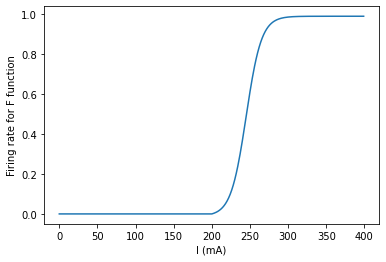

In [89]:
f = F(0.1*np.arange(-200,200), 1, 4.5)

fig = plt.plot(f)

plt.xlabel('I (mA)');
plt.ylabel('Firing rate for F function');

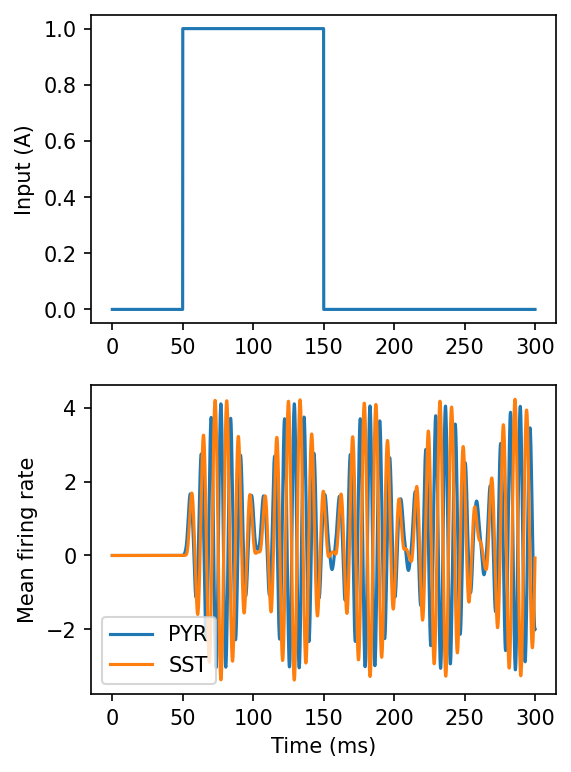

In [90]:
# initialiton
step_size = 0.1

tMin,tMax = 0.0,300.0
nSteps = (tMax-tMin)/step_size
tStep = (tMax-tMin)/nSteps

tPoints = np.arange(tMin, tMax, tStep)
sig_ou = 1
# Ornstein-Uhlenbeck Input
I_ou,range_t = my_OU(sig=sig_ou, myseed=2021,dt=0.1,dur=100.)
I_ext_E = np.zeros_like(tPoints)
I_ext_E[500:500+len(I_ou)] = I_ou
I_ext_E[500:500+len(I_ou)] = 1.0

I_ext_E[1600:1620] = 0. # to test different modalities
x1Points,v1Points = [],[]
x2Points,v2Points = [],[]
x3Points,v3Points = [],[]

# set initial conditions on the state variables
x1_0,v1_0 = 0.,0.
x2_0,v2_0 = 0.,0.
x3_0,v3_0 = 0.,0.

x1_0,v1_0 = 0.,0.
x2_0,v2_0 = 0.,0.
x3_0,v3_0 = 0.,0.
r = np.array([x1_0,v1_0,x2_0,v2_0,x3_0,v3_0], float)

# solve for the time evolution
for idx,t in enumerate(tPoints):
    x1Points += [r[0]]
    v1Points += [r[1]]
    x2Points += [r[2]]
    v2Points += [r[3]]
    x3Points += [r[4]]
    v3Points += [r[5]]
    r += runge_kutta4(wilson_cowan, r, t, tStep,I_ext_E[idx])
    #print(I_ext_E[idx])



fig, ax = plt.subplots(2, 1, figsize=(4, 6),  dpi= 150)

ax[0].plot(tPoints,I_ext_E)

#ax[0].set_xlabel('Time (ms)');
ax[0].set_ylabel('Input (A)');

pyr, = ax[1].plot(tPoints,x1Points)
sst, = ax[1].plot(tPoints,x2Points)
#vip, = ax[1].plot(tPoints,x3Points)

ax[1].legend([pyr, sst], ['PYR', 'SST'])
ax[1].set_xlabel('Time (ms)');
ax[1].set_ylabel('Mean firing rate');

#.xlabel("time (s)")
#ax[1].ylabel("rate")
#ax[1].legend(['PYR','SST','VIP'])
#ax[1].title("The Wilson-Cowan Model")

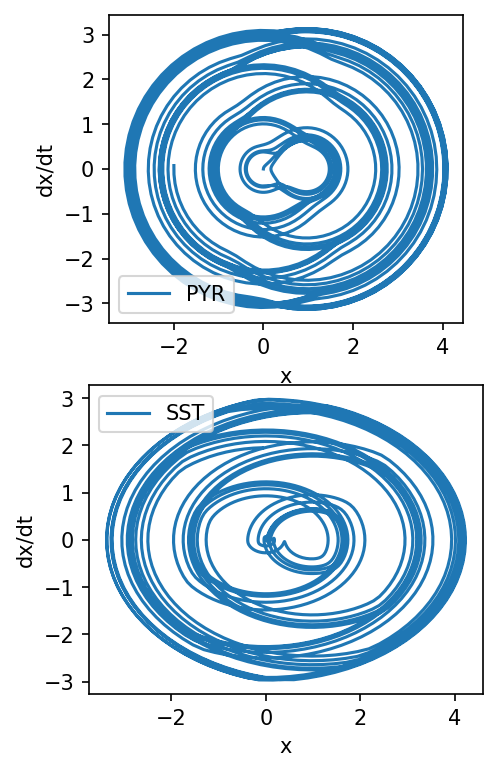

In [91]:
# state space figure
fig, ax = plt.subplots(2, 1, figsize=(4, 6),  dpi= 150)

pyr, = ax[0].plot(x1Points,v1Points)
sst, = ax[1].plot(x2Points,v2Points)
#vip, = ax[2].plot(x3Points,v3Points)

ax[0].legend([pyr], ['PYR'])
ax[0].set_xlabel('x');
ax[0].set_ylabel('dx/dt');
ax[0].set_aspect('equal')


ax[1].legend([sst], ['SST'])
ax[1].set_xlabel('x');
ax[1].set_ylabel('dx/dt');
ax[1].set_aspect('equal')


#ax[2].legend([vip], ['VIP'])
#ax[2].set_xlabel('x');
#ax[2].set_ylabel('dx/dt');
#ax[2].set_aspect('equal')

